<a href="https://colab.research.google.com/github/Wiaz24/LSTM/blob/backtesting/Backtested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install backtesting
!pip install ta

In [31]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import torch
import torch.nn as nn
import pandas_datareader as web
import datetime as dt
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from pathlib import Path
from tqdm.auto import tqdm
import os
from backtesting import Backtest, Strategy
import backtesting.lib
import ta
print(torch.__version__)

2.0.0+cu118


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir datasets

In [5]:
!cp drive/MyDrive/LunarData.csv datasets/LunarData.csv

### Hyprparameters

In [44]:
num_epochs = 10
learning_rate = 0.0001
train_perc = 0.60
batch_size = 32

input_size = 13
hidden_size = 256
num_lstm_layers = 3

seq_length = 48 # 1pkt = 5 minut
pred_length = 3 # 1pkt = 5 minut

### Download or load dataset

In [27]:
DATASETS_PATH = Path("datasets")
DATASETS_PATH.mkdir(parents=True, exist_ok=True)

#DATASET_NAME = "LunarData.csv"
DATASET_NAME = "BTC_USD.csv"
DATASET_SAVE_PATH = DATASETS_PATH / DATASET_NAME

#alldata = pd.read_csv(DATASET_SAVE_PATH)
#alldata.head()
start = dt.datetime(2023,4,1)
end = dt.datetime.now()
alldata = yf.download('BTC-USD', start = start, end = end, interval="5m")
print(f"Saving dataset to: {DATASET_SAVE_PATH}")
alldata.to_csv(DATASET_SAVE_PATH, index=False)

[*********************100%***********************]  1 of 1 completed
Saving dataset to: datasets/BTC_USD.csv


In [29]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11100 entries, 2023-04-01 00:00:00+00:00 to 2023-05-11 19:30:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       11100 non-null  float64
 1   High       11100 non-null  float64
 2   Low        11100 non-null  float64
 3   Close      11100 non-null  float64
 4   Adj Close  11100 non-null  float64
 5   Volume     11100 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 607.0 KB


In [33]:
rsi = ta.momentum.RSIIndicator(alldata['Close']).rsi()
rsi.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 11100 entries, 2023-04-01 00:00:00+00:00 to 2023-05-11 19:30:00+00:00
Series name: rsi
Non-Null Count  Dtype  
--------------  -----  
11087 non-null  float64
dtypes: float64(1)
memory usage: 173.4 KB


In [34]:
alldata['RSI'] = rsi

In [36]:
# Obliczenie EMA
ema10 = ta.trend.EMAIndicator(alldata['Close'], window=10).ema_indicator()
ema20 = ta.trend.EMAIndicator(alldata['Close'], window=20).ema_indicator()
ema50 = ta.trend.EMAIndicator(alldata['Close'], window=50).ema_indicator()

# Obliczenie SMA
sma10 = ta.trend.SMAIndicator(alldata['Close'], window=10).sma_indicator()
sma20 = ta.trend.SMAIndicator(alldata['Close'], window=20).sma_indicator()
sma50 = ta.trend.SMAIndicator(alldata['Close'], window=50).sma_indicator()

In [37]:
alldata['EMA10'] = ema10
alldata['EMA20'] = ema20
alldata['EMA50'] = ema50
alldata['SMA10'] = sma10
alldata['SMA20'] = sma20
alldata['SMA50'] = sma50

In [38]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11100 entries, 2023-04-01 00:00:00+00:00 to 2023-05-11 19:30:00+00:00
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       11100 non-null  float64
 1   High       11100 non-null  float64
 2   Low        11100 non-null  float64
 3   Close      11100 non-null  float64
 4   Adj Close  11100 non-null  float64
 5   Volume     11100 non-null  int64  
 6   RSI        11087 non-null  float64
 7   EMA10      11091 non-null  float64
 8   EMA20      11081 non-null  float64
 9   EMA50      11051 non-null  float64
 10  SMA10      11091 non-null  float64
 11  SMA20      11081 non-null  float64
 12  SMA50      11051 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.2 MB


### Data plot

In [43]:
data = alldata[50:].to_numpy()
data.shape

(11050, 13)

## Dataloading

In [ ]:
def sliding_windows(data, seq_length=1):
    x = []
    y = []

    # przykładowo: seq_lenght = 7, pred_length = 3, wtedy:
    for i in range(0, len(data) - seq_length - pred_length, pred_length):  # dla i = 0:
        _x = data[i:(i+seq_length), :]                      # _x = data[0:7, wszystkie cechy],  potem data[3:10,:]
        _y = data[i+seq_length:i+seq_length+pred_length, 0] # _y = data[7:10, open_price] ,    potem data[10:13,1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
outSc = MinMaxScaler()
outSc.fit_transform(data[:,1].reshape(-1,1))
data = sc.fit_transform(data) #normalizacja danych
x, y = sliding_windows(data, seq_length)  #tworzenie ramek uczących i odpowiedzi

print(f"x.shape = {x.shape}, y.shape = {y.shape}")                

x.shape = (1601, 48, 14), y.shape = (1601, 12)


In [ ]:
data[18000]

array([0.92927236, 0.93163396, 0.65263158, 0.04533333, 0.75      ,
       0.16183494, 0.35997495, 0.76190476, 0.22847813, 0.15465882,
       0.19042598, 0.02268431, 0.37775631, 0.07757378])

In [ ]:
train_size = int(len(y) * train_perc)
test_size = int((len(y) - train_size)/2)
eval_size = test_size

#device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
dataX = dataX.to(device)
dataY = dataY.to(device) 

dataset = TensorDataset(dataX, dataY)

indices = torch.randperm(len(dataset)-test_size)

### Losowanie próbek do zbioru uczącego i walidacyjnego

In [ ]:
train_indices = indices[:train_size]
eval_indices = indices[train_size:train_size+eval_size]
test_indices = torch.arange(train_size+eval_size, dataX.size(0))

In [ ]:
train_indices.shape, eval_indices.shape, test_indices.shape

(torch.Size([960]), torch.Size([320]), torch.Size([321]))

### Tworzenie dataloaderów

In [ ]:
trainDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
evalDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(eval_indices))
testDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(test_indices))

In [ ]:
features, labels = next(iter(trainDataLoader))
features.shape, labels.shape, features.device, labels.device

(torch.Size([32, 48, 14]),
 torch.Size([32, 12]),
 device(type='cpu'),
 device(type='cpu'))

## Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, pred_length, input_size, hidden_size, num_lstm_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = pred_length
        self.num_lstm_layers = num_lstm_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_lstm_layers, x.size(0), self.hidden_size).to(device))

        c_0 = Variable(torch.zeros(
            self.num_lstm_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        # Reshape for dense layer
        out = output[:, -1, :]
        
        out = self.fc(out)
        
        return out

## Training

In [ ]:
!git clone https://gist.github.com/NTT123/4596e5533e573c8ceab2f319ab5d36a2 jslog
import random
import math
import time
from jslog.jslogger import JSLogger

logger = JSLogger('train/test loss', ['train', 'test'])

Cloning into 'jslog'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18
Unpacking objects: 100% (18/18), 2.90 KiB | 594.00 KiB/s, done.


In [ ]:
%%time
logger.show()
lstm = LSTM(pred_length, input_size, hidden_size, num_lstm_layers)
lstm.to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in tqdm(range(num_epochs)):
    #uczenie modelu
    lstm.train()
    for inputs, labels in trainDataLoader:
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

    # ewaluacja modelu
    lstm.eval()
    with torch.inference_mode():
        for inputs, labels in evalDataLoader:
            outputs = lstm(inputs)
            loss = criterion(outputs, labels)
            eval_loss = loss.item()

    # wykres funkcji straty dla zbioru treningowego i ewaluacyjnego
    logger.log(epoch, {'train': train_loss, 'test': eval_loss})

  0%|          | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 1min 28s, sys: 7.51 s, total: 1min 35s
Wall time: 1min 38s


# Testing

In [ ]:
lstm.eval()
dataX.to('cpu')
with torch.inference_mode():
  predictions = lstm(dataX)
predictions = predictions.to('cpu')
dataY = dataY.to('cpu')

In [ ]:
predictions.shape, dataY.shape

(torch.Size([1601, 12]), torch.Size([1601, 12]))

In [ ]:
loss = criterion(predictions, dataY)
print(f"Loss = {loss}")

Loss = 0.0005354943568818271


In [ ]:
predictions_np = predictions.reshape(-1,1).data.numpy()
dataY_np = dataY.reshape(-1,1).data.numpy()

In [ ]:
predictions_np.shape, dataY_np.shape

((19212, 1), (19212, 1))

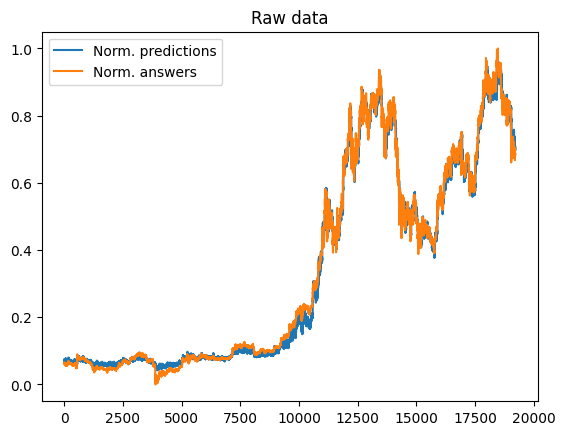

In [ ]:
plt.plot(predictions_np, label="Norm. predictions")
plt.plot(dataY_np, label="Norm. answers")
plt.legend()
plt.title("Raw data")
plt.show()

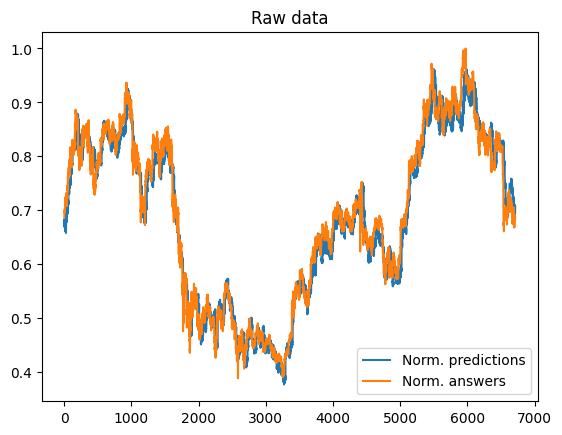

In [ ]:
plt.plot(predictions_np[12500:], label="Norm. predictions")
plt.plot(dataY_np[12500:], label="Norm. answers")
plt.legend()
plt.title("Raw data")
plt.show()

In [ ]:
dataY_np_unorm = outSc.inverse_transform(dataY_np)
predictions_np_unorm = outSc.inverse_transform(predictions_np)

In [ ]:
dataY_np_unorm[:3], dataY_np[:3]

(array([[8658.167],
        [8641.568],
        [8759.063]], dtype=float32),
 array([[0.06396887],
        [0.06371072],
        [0.06553807]], dtype=float32))

In [ ]:
_dates = dates[seq_length : seq_length+dataY_np.size]
print(_dates.size)

19212


In [ ]:
int(train_size+eval_size)

1280

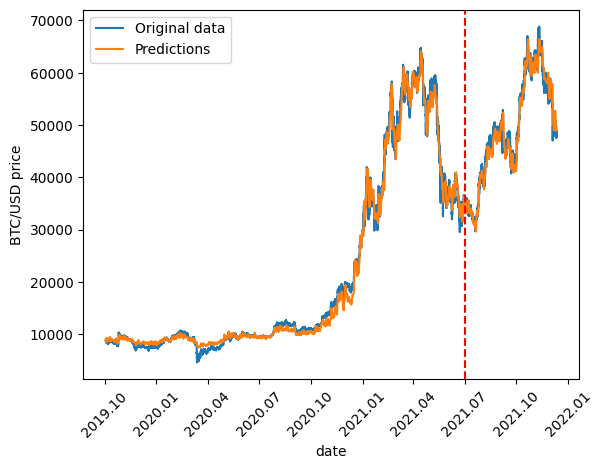

In [ ]:
# Tworzenie wykresu
fig, ax = plt.subplots()
ax.plot(_dates, dataY_np_unorm, label="Original data")
ax.plot(_dates[::pred_length], predictions_np_unorm[::pred_length], label="Predictions")
ax.axvline(x=_dates[(train_size+eval_size)*pred_length], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()

# plt.plot(predictions_np_unorm, label="predictions")
# plt.plot(dataY_np_unorm, label="answers")
# plt.legend()
# plt.title("Predicted data")
# plt.show()

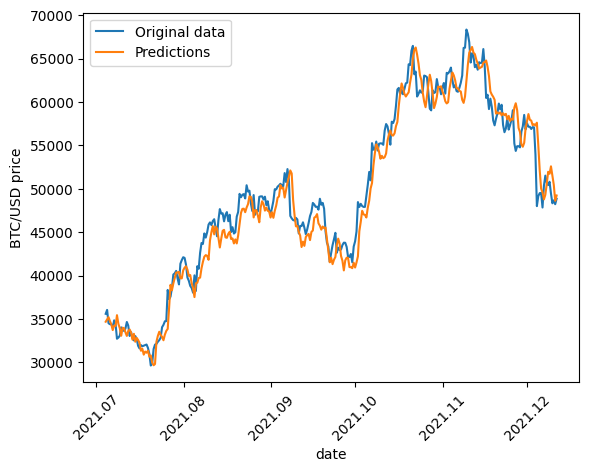

In [ ]:
# Tworzenie wykresu
fig, ax = plt.subplots()
startInd = int(_dates.size*(train_perc+1)/2)
ax.plot(_dates[startInd:][::pred_length], dataY_np_unorm[startInd:][::pred_length], label="Original data")
ax.plot(_dates[startInd:][::pred_length], predictions_np_unorm[startInd:][::pred_length], label="Predictions")
#ax.axvline(x=dates[train_size], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()

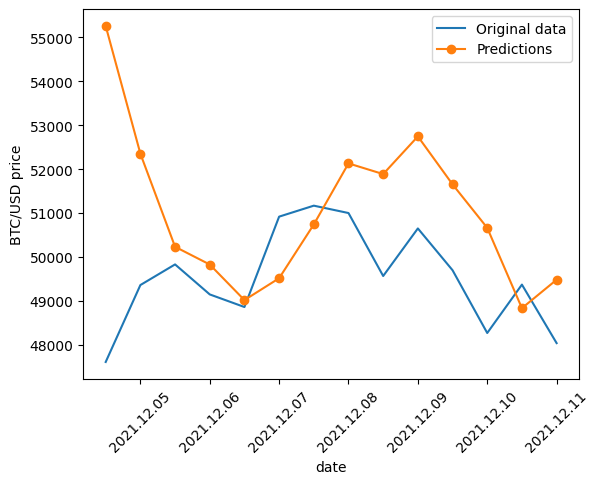

In [ ]:
# Tworzenie wykresu
fig, ax = plt.subplots()
startInd = int(_dates.size*train_perc)
ax.plot(_dates[-168:][::pred_length], dataY_np_unorm[-168:][::pred_length], label="Original data")
ax.plot(_dates[-168:][::pred_length], predictions_np_unorm[-168:][::pred_length], marker='o', linestyle='-', label="Predictions")
#ax.axvline(x=dates[train_size], c='r', linestyle='--')
# Ustawienie formatu daty
date_form = DateFormatter("%Y.%m.%d")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel("date")
plt.ylabel("BTC/USD price")
ax.legend()
# Rotacja etykiet osi X
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()